# Demostration WMC

In [1]:
import numpy as np
import datetime
import threading
import multiprocessing as mp
from matplotlib import pyplot as plt
from time import time
from scipy.stats import norm
import sympy
%matplotlib inline
plt.style.use('bmh')
import scipy
from scipy import stats
from scipy import sparse
from scipy.sparse import linalg
from scipy.sparse.linalg import spsolve
from scipy.stats import norm

In [2]:
z = sympy.symbols('z')
K0 = 1e-6
K1 = 6e-3# m / s
Aalpha = 0.5
c=20
w=0

sym_Diffu =  K0 + K1 * z * sympy.exp(-Aalpha * z)#*(sympy.tanh(c*(z+0.05)))
sym_dKdz = sympy.diff(sym_Diffu, z, 1)
sym_Beta = sympy.sqrt(2 * sym_Diffu)
sym_dBdz = sympy.diff(sym_Beta, z, 1)
sym_ddBdzz = sympy.diff(sym_Beta, z, 2)
sym_Alpha = w + sym_dKdz
sym_dAdz = sympy.diff(sym_Alpha, z, 1)
sym_ddAdzz = sympy.diff(sym_Alpha, z, 2)
sym_dABdz = sympy.diff(sym_Alpha * sym_Beta, z, 1)

Diffu  =  sympy.utilities.lambdify(z,          sym_Diffu,np)
dKdz   =  sympy.utilities.lambdify(z,          sym_dKdz,np)
Beta   =  sympy.utilities.lambdify(z,          sym_Beta,np)
dBdz   =  sympy.utilities.lambdify(z,          sym_dBdz,np)
ddBdzz=  sympy.utilities.lambdify(z,          sym_ddBdzz,np)
Alpha =  sympy.utilities.lambdify(z,      sym_Alpha,np)
dAdz  =  sympy.utilities.lambdify(z,      sym_dAdz,np)
ddAdzz=  sympy.utilities.lambdify(z,      sym_ddAdzz,np)
dABdz =  sympy.utilities.lambdify(z, sym_Alpha*sym_Beta,np)

### Functions

In [3]:
def Gaussian(z, mu, sigma):
    return 1 / np.sqrt(2 * np.pi * sigma**2) * np.exp(-(
        (z - mu) / sigma)**2 / 2)


def FTCS(C0, K0, Z, dt, Tmax):
    dZ = Z[1] - Z[0]

    #Assume K do not depen on time.
    #We need two extra ghost points at the start and the end.
    dKdz = np.empty(K0.shape[0], dtype=float)
    dKdz[1:-1] = (K0[2:] - K0[:-2]) / (2 * dZ)
    dKdz[0] = 0
    dKdz[-1] = 0

    #We need two extra ghost points at the start and the end.
    extended_C = np.empty(C0.shape[0] + 2, dtype=float)

    for i in range(int(Tmax/dt)):
        extended_C[1:-1] = C0.copy()
        extended_C[0] = extended_C[2]
        extended_C[-1] = extended_C[-3]

        dC = dKdz * (extended_C[2:] - extended_C[0:-2]) / (2 * dZ) + K0 * (extended_C[2:] - 2 * extended_C[1:-1] + extended_C[0:-2]) / (dZ**2)

        dC = dt * dC
        C0 = C0 + dC

    return C0


def crankNicolson(C0, D0, X, dt, Tmax):
    # Numerical parameters
    dx = X[1] - X[0]
    Nx = X.size
    Nt = int(Tmax / dt)
    a = dt / (8 * dx**2)
    b = dt / (4 * dx)

    # Problem arrays
    # Pad with halo cells and
    # copy elements onto boundary
    #C      = np.zeros((Nt+1, Nx))
    C = C0.copy()
    # Diffusivity (here constant in time)
    #D      = np.zeros(Nx)
    D = D0.copy()
    # Create system matrices
    # Equation is L C_i = R C_{i+1}
    # Left hand side
    L = np.zeros((Nx, Nx))
    # Fill non-boundary points first
    L[1:-1, 1:-1] += np.diag(1 - 8 * a * D[1:-1], 0)
    L[:-1, :-1] += np.diag(-a * (D[2:] - D[:-2]) + 4 * a * D[1:-1], -1)
    L[1:, 1:] += np.diag(a * (D[2:] - D[:-2]) + 4 * a * D[1:-1], +1)
    # No-diffusive-flux BC at top
    L[0, 0] = 1 - 8 * a * D[0]
    L[0, 1] = 8 * a * D[0]
    # No-diffusive-flux  BC at bottom
    L[-1, -1] = 1 - 8 * a * D[-1]
    L[-1, -2] = 8 * a * D[-1]
    # Convert to sparse matrix
    L = scipy.sparse.csr_matrix(L)
    # Right hand side
    R = np.zeros((Nx, Nx))
    # Fill non-boundary points first
    R[1:-1, 1:-1] += np.diag(1 + 8 * a * D[1:-1], 0)
    R[:-1, :-1] += np.diag(a * (D[2:] - D[:-2]) - 4 * a * D[1:-1], -1)
    R[1:, 1:] += np.diag(-a * (D[2:] - D[:-2]) - 4 * a * D[1:-1], +1)
    # No-diffusive-flux  BC at top
    R[0, 0] = 1 + 8 * a * D[0]
    R[0, 1] = -8 * a * D[0]
    # No-diffusive-flux  BC at bottom
    R[-1, -1] = 1 + 8 * a * D[-1]
    R[-1, -2] = -8 * a * D[-1]
    # Convert to sparse matrix
    R = scipy.sparse.csr_matrix(R)
    # We do not need the history of the concetration
    #C=C[0,:]
    for t in range(Nt):
        x = L.dot(C)
        C = spsolve(R, x)
    return C

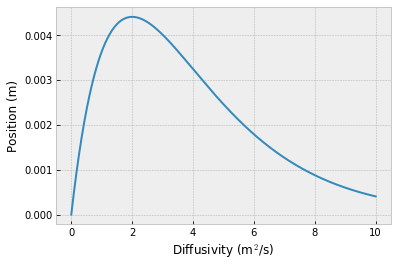

In [4]:
x = np.linspace(0, 10, 2000)
K = Diffu(x)

plt.plot(x, K)
plt.ylabel("Position (m)")
plt.xlabel("Diffusivity (m$^2$/s)")
plt.tight_layout
plt.show()


In [17]:
y0 = np.cos(2*np.pi*x) + 2
time =3600

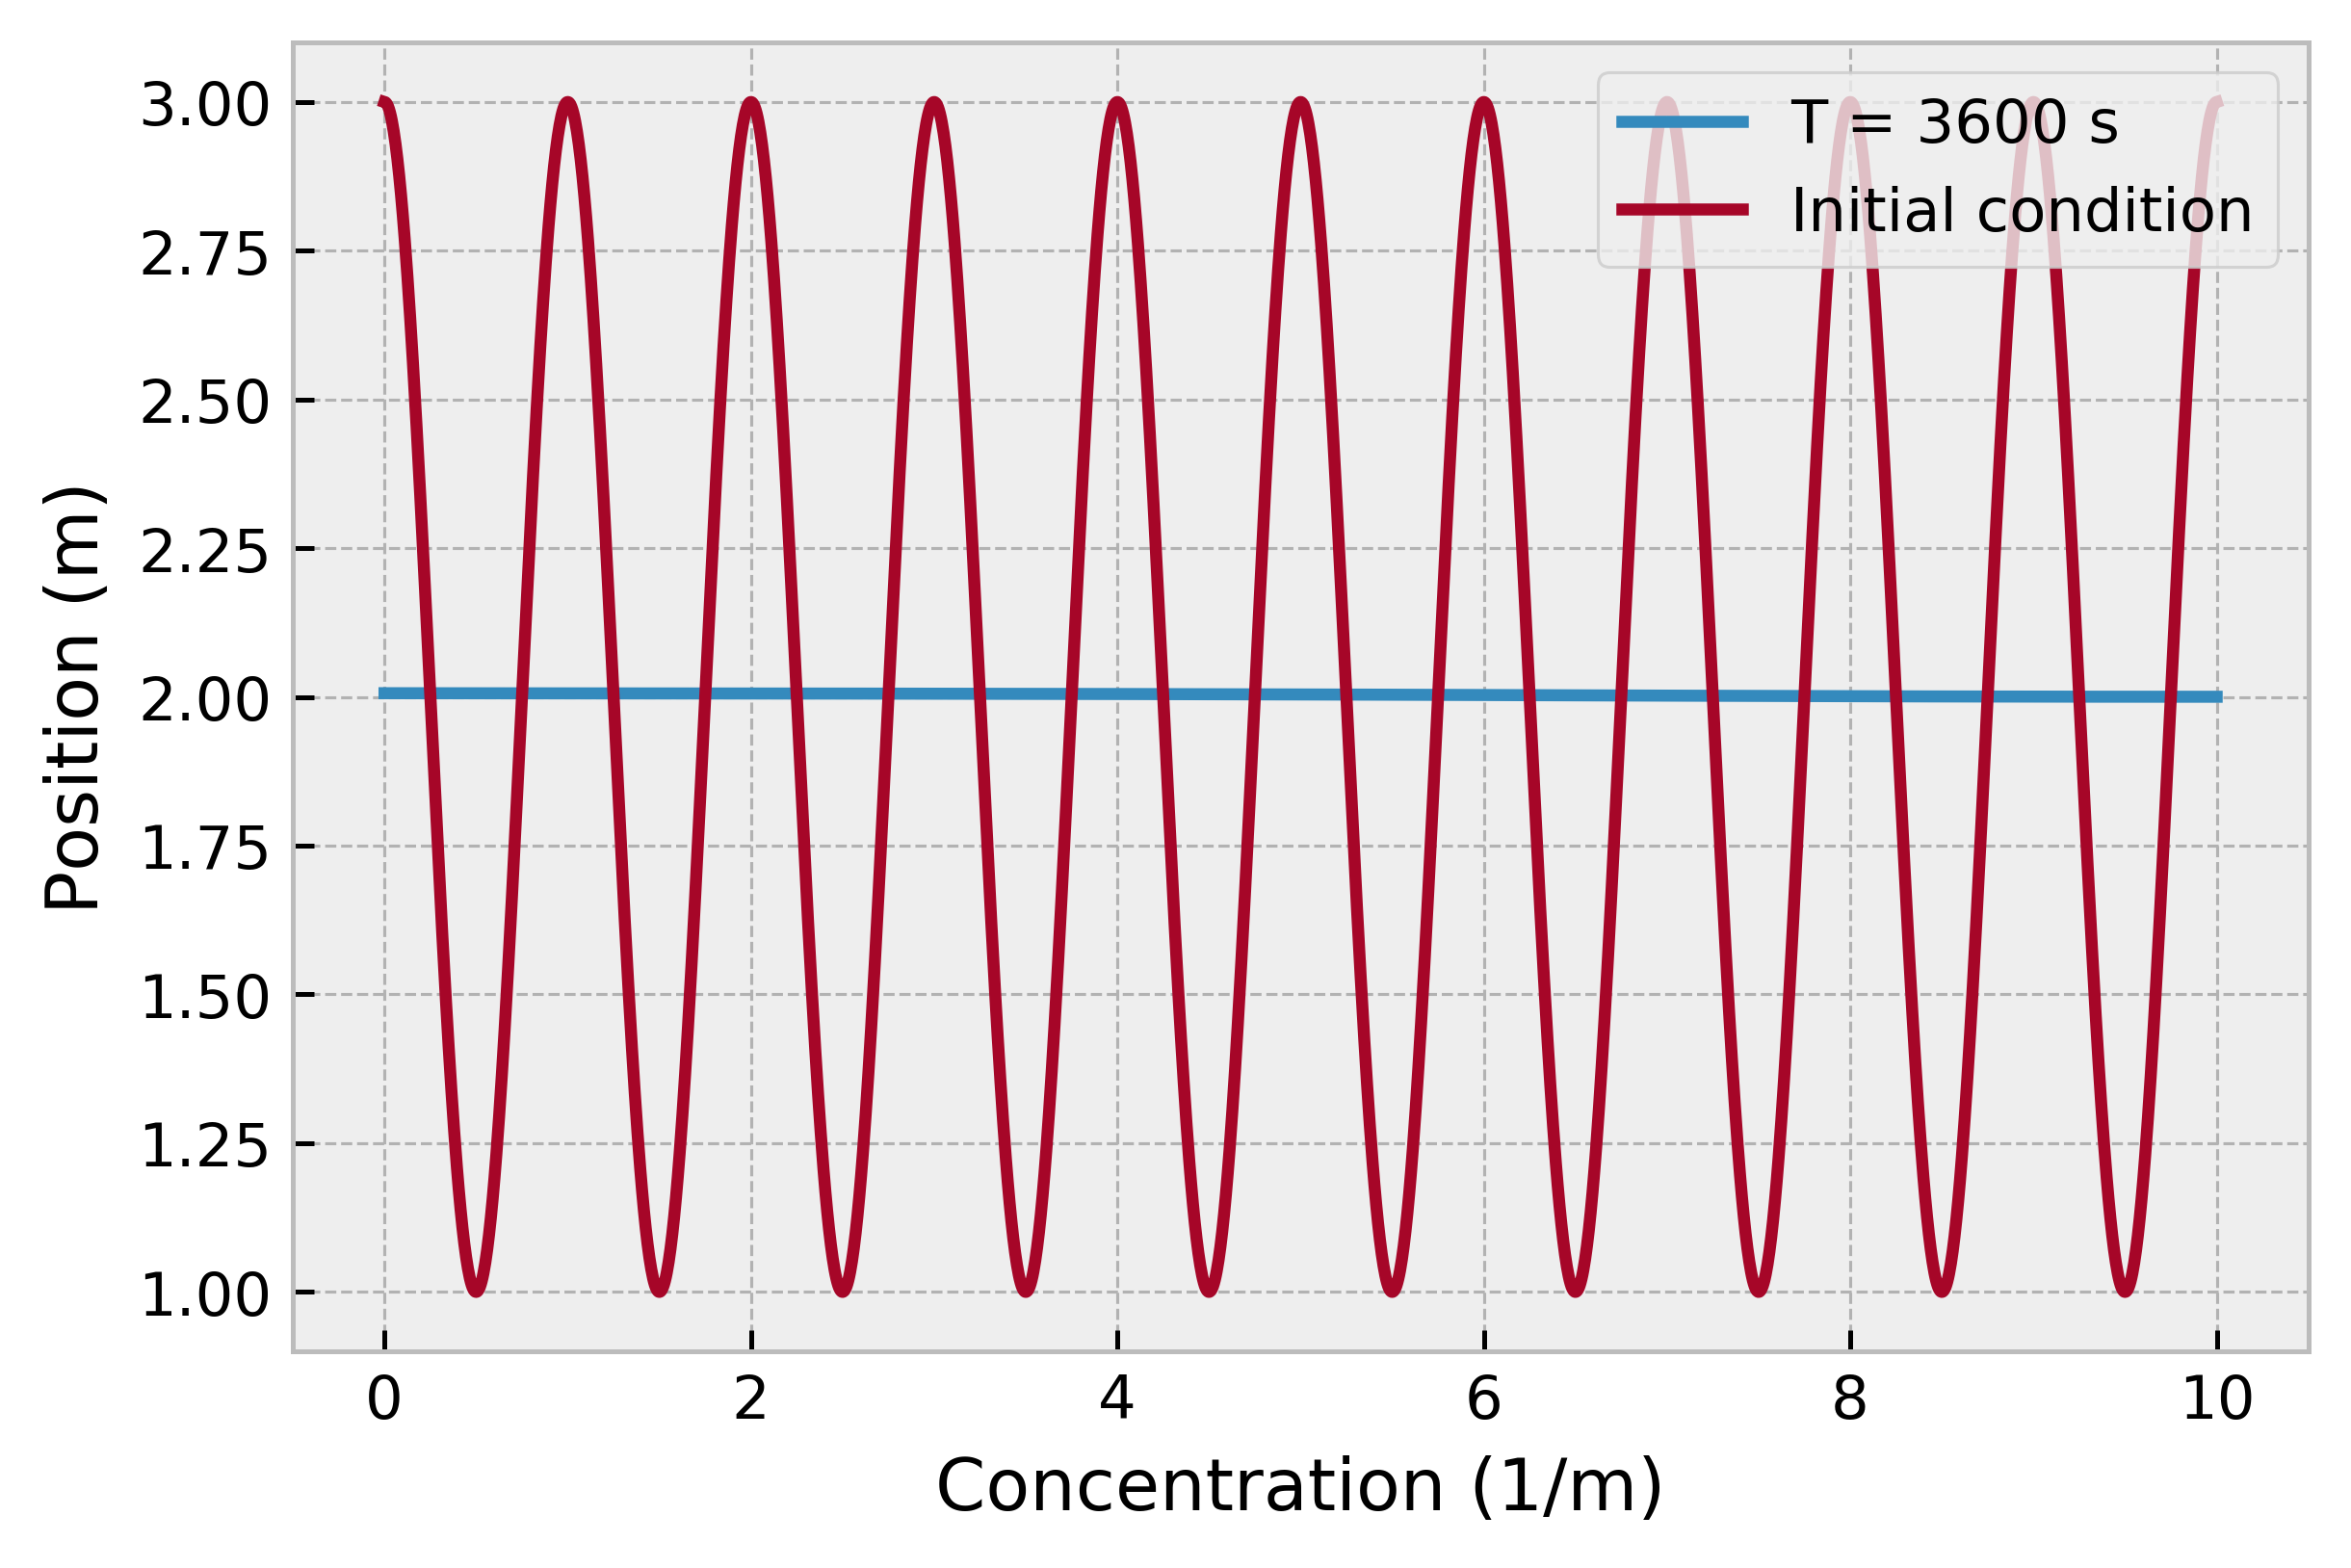

In [21]:
#y = crankNicolson(y0, K, x, 0.5, time) # CrankNicolson is much faster and give same resualt
y = FTCS(y0, K, x, 0.001, time)

plt.figure(dpi=450)
plt.plot(x, y, label = "T = 3600 s")
plt.plot(x, y0, label = "Initial condition")
plt.ylabel("Position (m)")
plt.xlabel("Concentration (1/m)")
plt.legend(loc = 1)
plt.tight_layout
plt.show()

In [12]:
y0 = np.random.uniform(1.5, 2.5, x.size)
time =3600

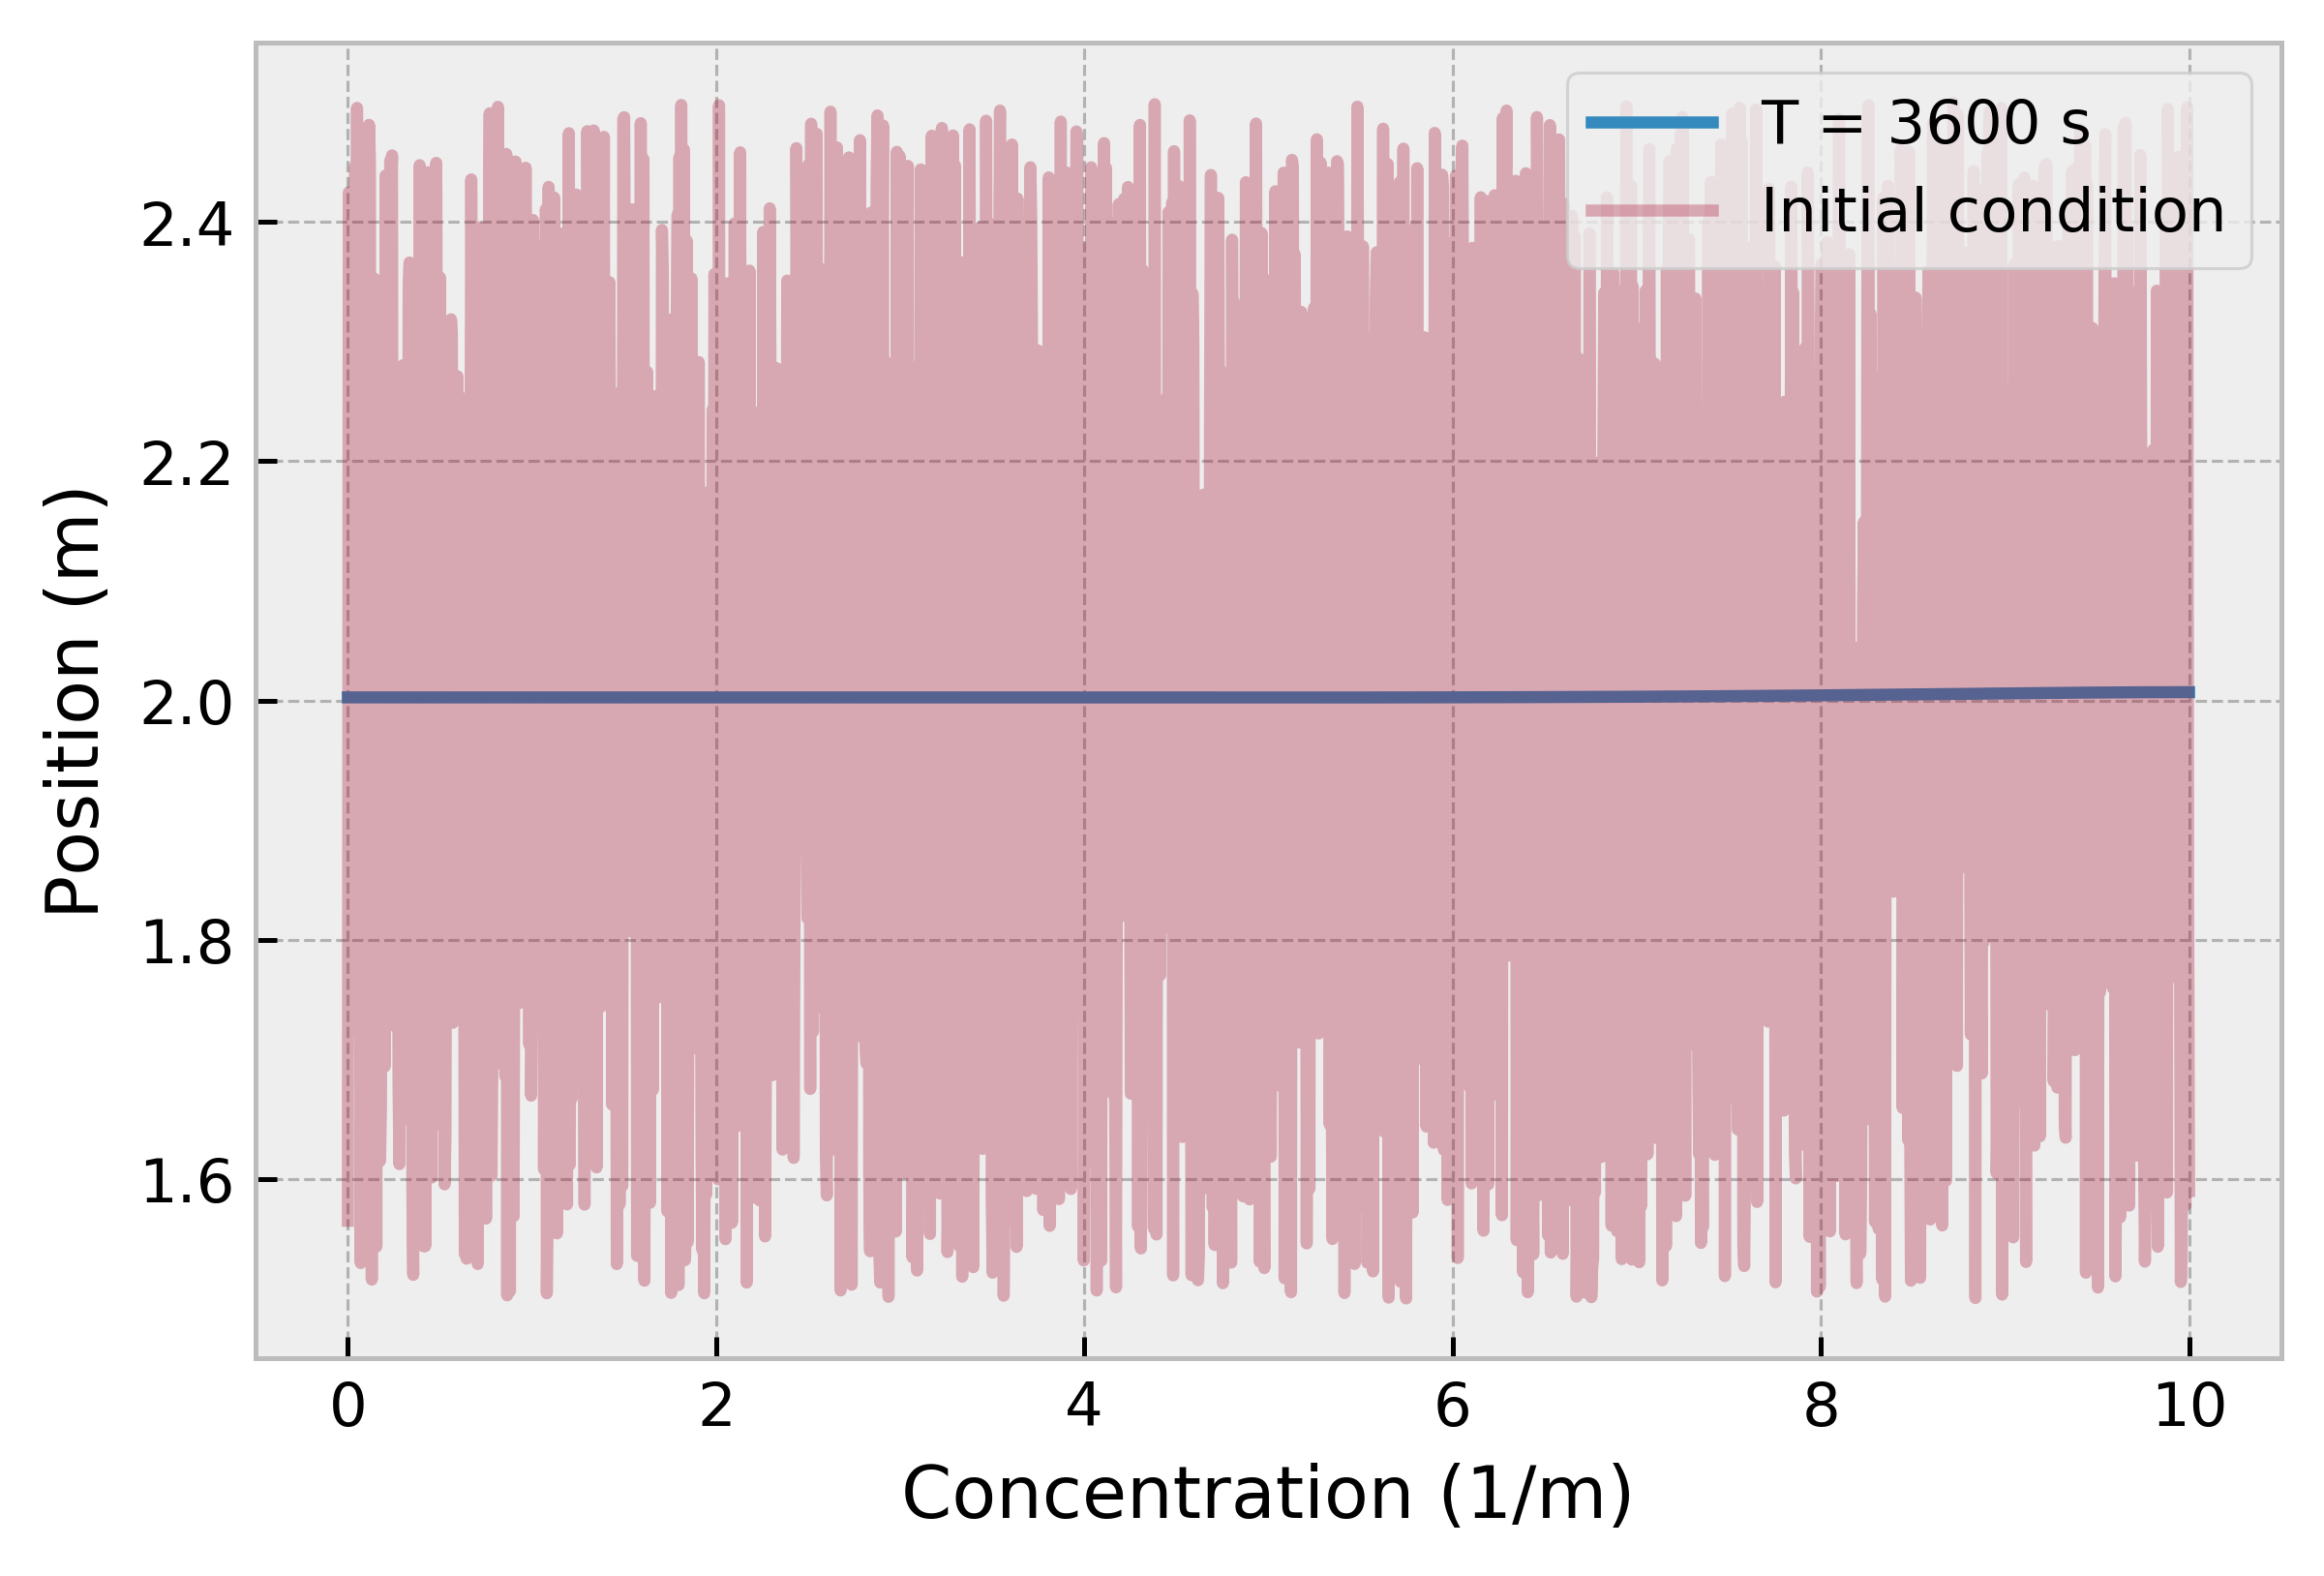

In [14]:
#y = crankNicolson(y0, K, x, 0.5, time) # CrankNicolson is much faster and give same resualt
y = FTCS(y0, K, x, 0.001, time)

plt.figure(dpi=450)
plt.plot(x, y, label = "T = 3600 s")
plt.plot(x, y0, label = "Initial condition", alpha = 0.3)
plt.ylabel("Position (m)")
plt.xlabel("Concentration (1/m)")
plt.legend()
plt.tight_layout
plt.show()